# Projet 6: Détection de Faux billet
<br/>

- Pour ce projet, nous devons créer un algorithme qui puisse détecter les faux billets afin de lutter contre la criminalité.
Nous disposons du jeu de données fourni par la police judicière

In [1]:
# importons les bases de donées pour l'analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing

import scipy.stats as scs

In [2]:
# Importations du pipeline d'aide à la l'analyse fourni dans le cours "Réalisez une étude de données" d'open Classrooms
from function import *

In [3]:
# importons de notre échantillon
infos_billet= pd.read_csv("dataset_p5/notes.csv")

# Mission 0 : Decription des données ( analyses uni et bivariées)

In [4]:
infos_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [5]:
# inspectons le contenu
infos_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [6]:
infos_billet.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

* Nous notons qu'il n'y a pas de valeur muanquante dans nos données. Pour les 170 individus recencés toutes les variables sont remplies

## Statistique descriptive
Etudions la distribution de nos variables et les corrélations entre elles.

In [7]:
#  affichons la statistique élémentaire de nos données
infos_billet.describe()


,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


- Notre jeu de donné semble correct pas de valeur abérante
- Nous noterons que pour chacunes de ces variables l'écart type sembles normal excepté pour les variables marge du bord inférieur (s = 0.70) et la longueur (0.92) du billet qui présente une population très hétérogène leur écart type est trop élevé et nous pouvont déja comprendre que ces deux variables sont importantes pour la détection du type de billet.


In [8]:
# # nombre de vrai et de faux billet de notre jeu de données.
infos_billet['is_genuine'].value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

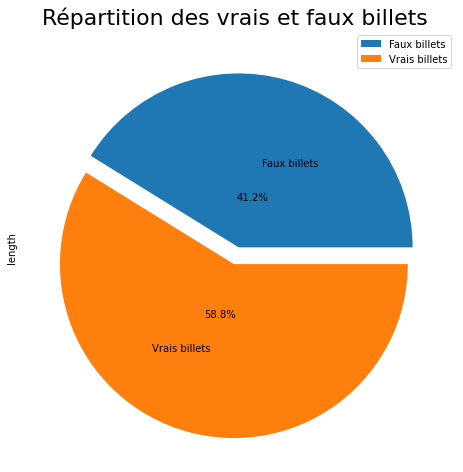

In [9]:
# représentation des proportion de vrais et de faux billets
nb_is_genuine = infos_billet.groupby('is_genuine').count()
nb_is_genuine.plot.pie(y="length",figsize=(8, 8),
                                explode = [0, 0.1],
                                labels = ["Faux billets", "Vrais billets"],
                                autopct = '%1.1f%%',
                                pctdistance = 0.3, labeldistance = 0.5)

plt.title('Répartition des vrais et faux billets ', 
  loc='center', 
  fontsize=22)
plt.savefig('../P6/image/distributions_variables_cible.png')

### Vérifions la ditribution de nos variables

In [10]:
#créons une fonction qui calcul les éléments statistiques de chaque vriables et les représente dans un histogramme"
def var_hist(var, i):
    subset = infos_billet[var]
    n_infos_billet = len(infos_billet)
    xbar = np.mean(infos_billet[var]) # Moyenne
    sprime = np.std(infos_billet[var], ddof=1) # Ecart-type
    sprime2 = np.var(infos_billet[var], ddof=1) #Variance non biaisée
    ax = fig.add_subplot(i)
    ax.hist(subset, density=True)
    ax.axvline(xbar, color='r', linewidth=2, label="Moyenne empirique")
    bins = np.arange(infos_billet[var].min(),infos_billet[var].max(),0.05)
    y = scs.norm.pdf(bins, xbar, sprime)
    ax.plot(bins, y, '--', label="Densité normale")
    ax.legend()
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Densité', fontsize=12)
    ax.set_title('Distribution de '+str(var), fontsize=18)

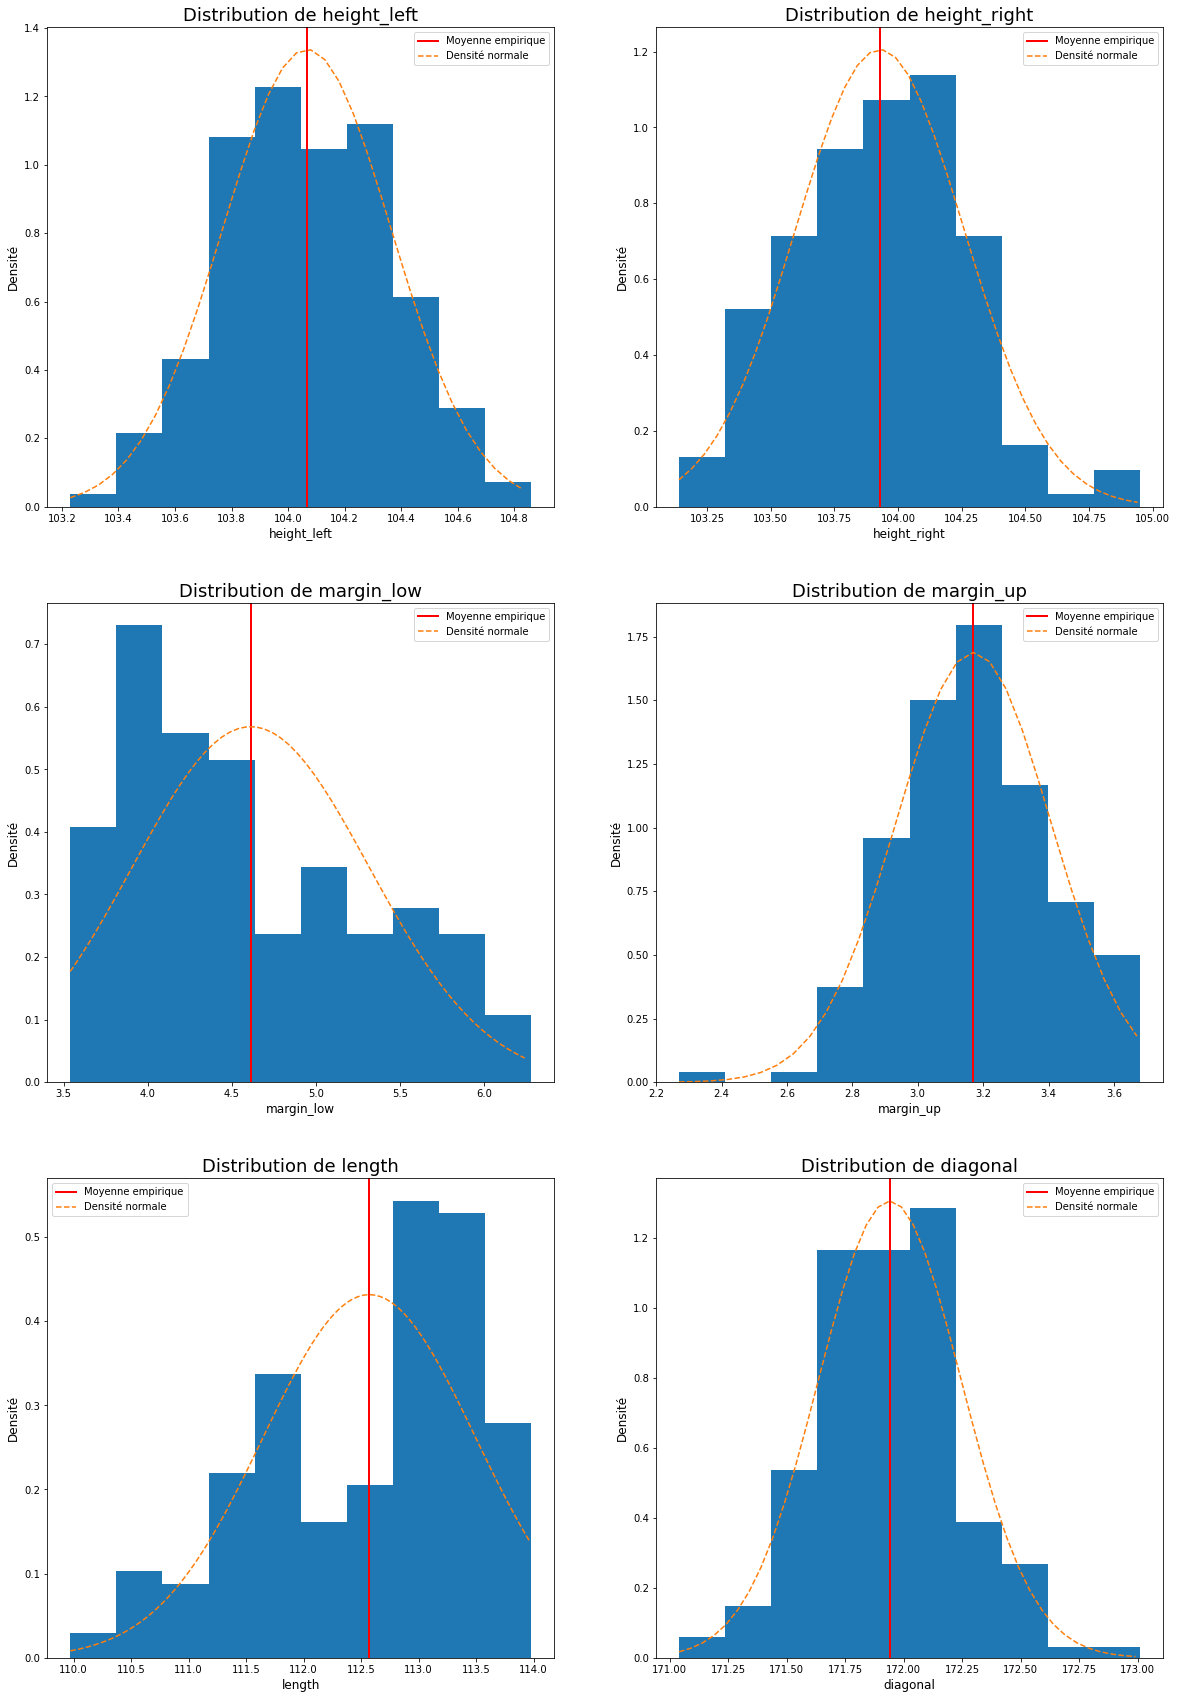

In [11]:

liste_var = ["height_left","height_right","margin_low","margin_up","length","diagonal"]

fig = plt.figure(figsize=(20,30),constrained_layout=False)
i = 321
for var in liste_var :
    var_hist(var, i)
    i+=1
fig.savefig('../P6/image/Description_distributions_variables.png')

**A vu d'oeil nous pouvons constater que certaines variables suivent une distribution normale contrairement à d'autre. vérifions cela avec le test de kolmogorov smirnov.

### Test de kolmogorov smirnov sur les variables.

In [12]:
liste_var = liste_var # affectons la liste de nos variables à liste_var
for var in liste_var :
    print(var,":",scs.ks_2samp(infos_billet[var],list(np.random.normal(np.mean(infos_billet[var]), np.std(infos_billet[var]), 1000))))

height_left : KstestResult(statistic=0.07064705882352941, pvalue=0.44055294115641175)
height_right : KstestResult(statistic=0.04923529411764706, pvalue=0.8533147399284665)
margin_low : KstestResult(statistic=0.1053529411764706, pvalue=0.07335900923899707)
margin_up : KstestResult(statistic=0.04047058823529412, pvalue=0.9624283694446748)
length : KstestResult(statistic=0.14323529411764707, pvalue=0.004562807799133872)
diagonal : KstestResult(statistic=0.058823529411764705, pvalue=0.6712377908214517)


Conclusion sur les test statistiques
- les p values obtenues ne permettent pas de rejetter l'hypothèse nulle pour les variables height_left , height_right , margin_up, diagonal  elles sont donc distribuées suivant une loi normale
- les variables length  et margin_low  ne suivent pas une loi normale car leur pvalue < au niveau de test de 5%

### Analyse bivariée

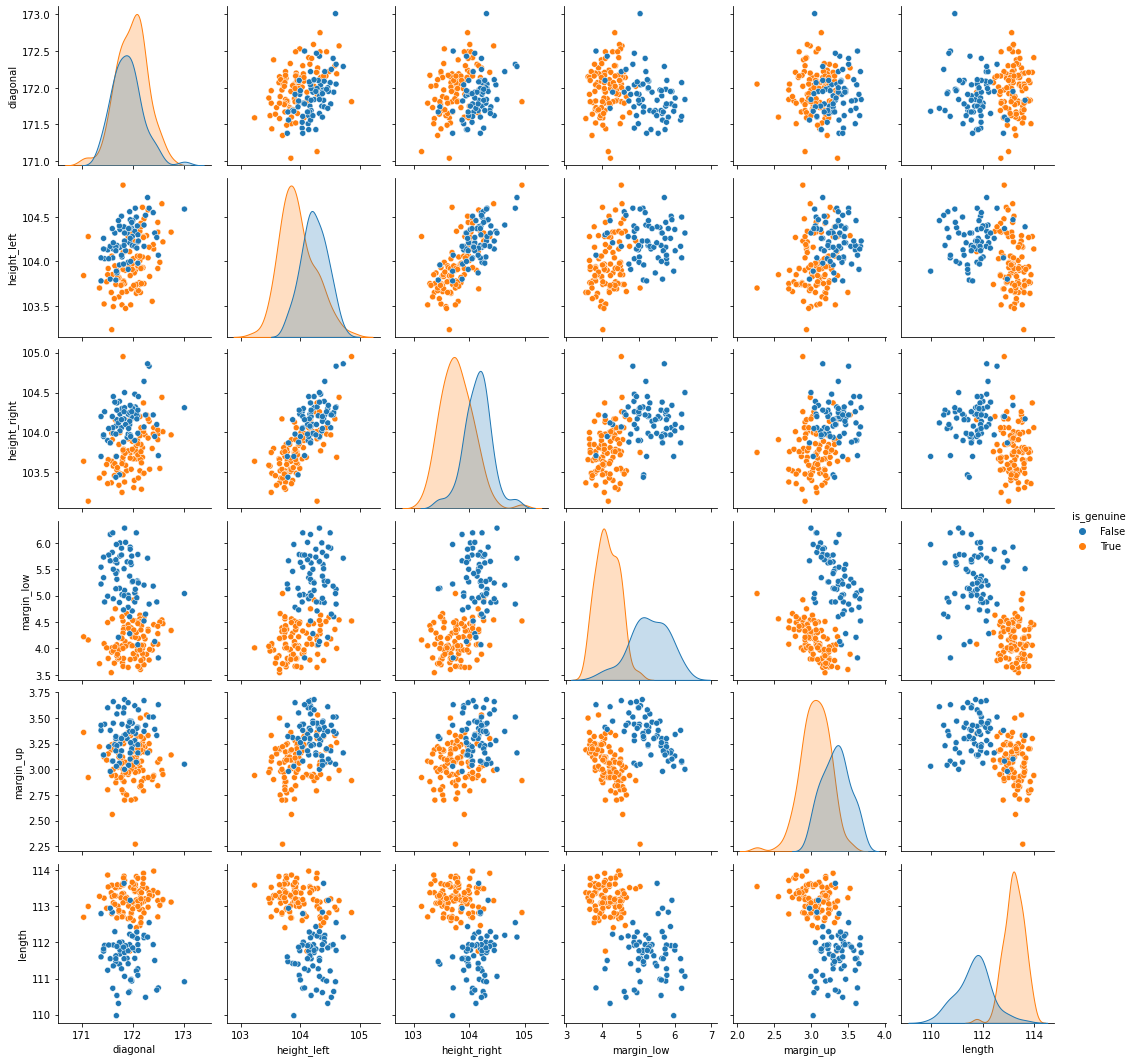

In [13]:
import seaborn
seaborn.pairplot(infos_billet,hue='is_genuine')
plt.show
plt.savefig('../P6/image/Relation entre variables deux à deux.png')

On remarque bien deux groupes qui représente le type de billet matérialisés par les couleurs bleu et rouge 
on note aussi des corrélations suivantes entre les variables:
* corrélation linéaire positive entre hauteur à droite et la hauteur à gauche
* corrélation la marge supérieur et l'image et la longueur


### Regardons en détail la correlation entre l'authenticité d'un billet et chacune des variables

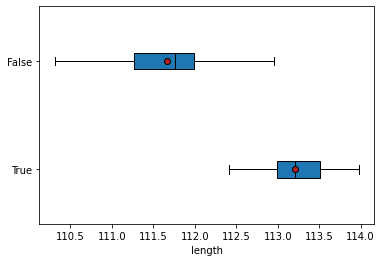

In [14]:
# diagramme de dispertion entre les variable is_genuine et length
x= 'length'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['length'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('length')
plt.savefig("../P6/image/distribution de la length et is_genuine.png")

* Les faux billets sont moins longs que les vrai ils ne dépassent pas  113.0 mm
* les vrais billet sont plus long et dépasse souvent les 1130.0 mm
la longuer moyenne des faux et vrai billets sont différentes ( 

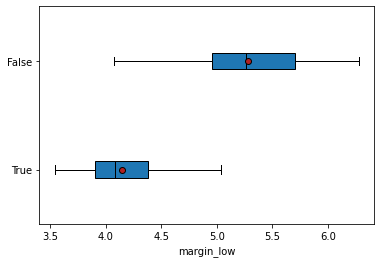

In [15]:
# diagramme de dispertion entre les variable is_genuine et margin_low
x= 'margin_low'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['margin_low'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('margin_low')
plt.savefig("../P6/image/distribution de la margin_low et is_genuine.png")

* les faux billets ont des large élevées qui dépassent 5.0 mm alors que les vrais billets ne dépassent pas 5.0mm

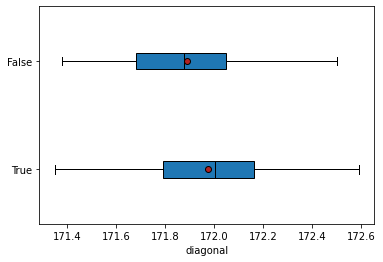

In [16]:
#diagramme de dispertion entre les variable is_genuine et diagonal
x= 'diagonal'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['diagonal'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('diagonal')
plt.savefig("../P6/image/distribution de la diagonal et is_genuine.png")

* La variable diagonal n'est pas assez significative pour distinguer un vrai d'un faux billet ils ont des moyennes presque égales 

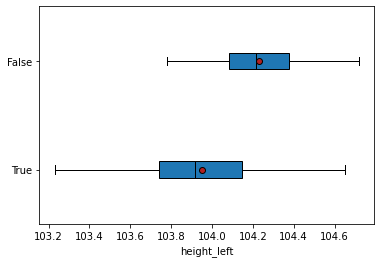

In [17]:
# diagramme de dispertion entre les variable is_genuine et v
x= 'height_left'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['height_left'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('height_left')
plt.savefig("../P6/image/distribution de la height_left et is_genuine.png")

* les faux billets ont des grandes longueurs gauche élevées et ne déscendent pas à moins de 103.8 mm pour les vrais billets, ces logueurs déscendent bien bas.

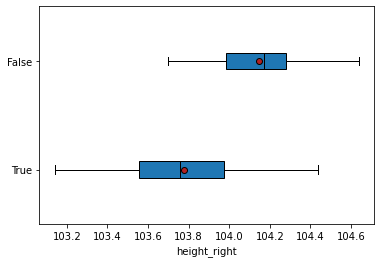

In [18]:
# diagramme de dispertion entre les variable is_genuine et height_right
x= 'height_right'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['height_right'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('height_right')
plt.savefig("../P6/image/distribution de height_right et is_genuine.png")

* les faux billets ont des hauteurs à droite qui ne déscendent pas à moins de 103.7 mm par contre les vrais billets peuvent avoir des hauteurs droite bien basse.

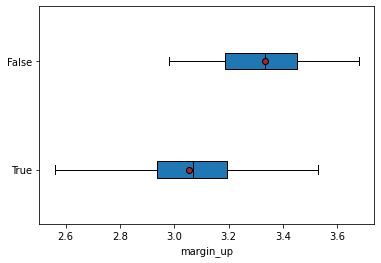

In [19]:
# diagramme de dispertion entre les variable is_genuine et margin_up
x= 'margin_up'
y= 'is_genuine'

modalites = infos_billet['is_genuine'].unique()
groupes = []
for m in modalites:
    groupes.append(infos_billet[infos_billet['is_genuine']==m]['margin_up'])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('margin_up')
plt.savefig("../P6/image/distribution de margin_up et is_genuine.png")

In [20]:
infos_billet.groupby('is_genuine').mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


* les faux billets ont des marges entre le bord supérieur et l'image qui sont supérieur à 3.0 mm
* les vrais billets eux ils descendent plus bas.

Les variables qui semblent les plus discriminantes sont:

- length
- Margin_low

Bien qu'on puisse aussi s'intéresser aux valeurs minimales ou maximales des billets pour le classer en fonction des variables
- Margin_up
- heigh_ right


## MISSION 1 : Réalisons une ACP


In [21]:
# Préparons nos données pour l'ACP

infos_billet_pca = infos_billet[['diagonal','height_left','height_right','margin_low','margin_up','length']]

X = infos_billet_pca.values
names = infos_billet['is_genuine'] # ou infos_billet.index pour avoir nos variables illustratives
features = infos_billet_pca.columns


In [22]:
infos_billet_pca.shape
n = infos_billet_pca.shape[0]
print(n)
p = infos_billet_pca.shape[1]
print(p)

170
6


In [23]:
infos_billet_pca.sample()

,diagonal,height_left,height_right,margin_low,margin_up,length
10,172.27,104.29,104.22,3.89,3.53,113.5


In [24]:
# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [25]:
# choix du nombre de composant à calculer. Par defaut , ce nombre est souvent égale au nombre de variable
n_comp = 6 # nous allons limiter ce nombre à 3

In [26]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


PCA(n_components=6)

In [27]:
coord = pca.fit_transform(X_scaled)
coord

array([[ 2.15363875,  1.59970945,  1.78745079,  2.43346523,  0.69968952,
        -1.26770217],
       [-2.11041589, -0.52603892,  0.54256277,  0.34454951,  0.0674404 ,
        -0.54460079],
       [-1.97315242, -0.04810178,  0.85871563,  0.37481231, -0.4248861 ,
         0.08048667],
       ...,
       [ 2.06724502,  0.84560244, -0.61028227, -1.71417169,  0.1169579 ,
        -0.50433787],
       [ 0.73925685, -0.97296457, -1.35977212, -0.19173617, -0.24355701,
         0.21142914],
       [ 1.50499242, -1.07972486,  0.18888855, -1.34755225, -0.2891493 ,
        -0.06034599]])

In [28]:
X_scaled

array([[-0.42834385,  2.6694537 ,  3.09656321, -0.13159013, -1.18987367,
         0.28163308],
       [-0.88755932, -1.09769709, -0.69125444, -0.86012554, -1.27473985,
         0.78069736],
       [-0.36274164, -1.03042654, -0.50943919, -0.30301023, -1.23230676,
         1.37740465],
       ...,
       [ 1.73652911,  0.68497248,  0.52084721,  0.38267015,  0.67718214,
        -2.05094997],
       [-0.39554274, -0.32408577, -0.1458087 ,  0.16839504,  1.61071005,
        -0.75989238],
       [ 0.06367273, -0.22317994,  0.06630909,  1.45404575,  0.38015054,
        -1.74717171]])

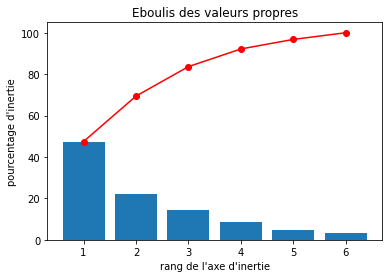

In [29]:
# Eboulis des valeurs propres
display_scree_plot(pca)

In [30]:
# Attribut du modèle PCA pour retrouver la quantité de variance expliquée par chaque composante
valeur_propre=pca.explained_variance_

In [31]:
# Attribut du modèle PCA pour retrouver le pourcentage  de variance expliquée par chaque composante
pca.explained_variance_ratio_

array([0.47447921, 0.21957106, 0.14234524, 0.08526295, 0.04612822,
       0.03221331])

### Cercle de corrélation

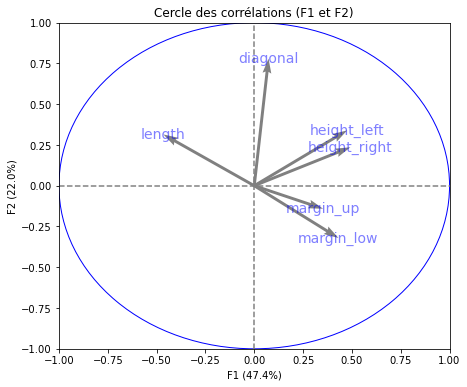

In [32]:
#affichons le Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

**sur F1**:
- Les variables height_left et height_right contribuent le plus  à sa formation et sont également corrélé positivement à cet axes 

- les variables margin-up et margin-low contribuent positivement à la l'axe 1

- la variable lenght est corrélé négativement  l'axe.

**Sur F2**: 

- c'est la variable Diagonale qui explique exclusivement cet axe elle contribue grandement à la construction de cet axe et y est corrélé positivement 

## Matrice de corrélation entre les variables

In [33]:
cor_var = infos_billet.corr(method='pearson')
cor_var

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.139223,-0.461730,-0.551309,-0.800111,-0.582801,0.825743
diagonal,0.139223,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,-0.461730,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,-0.551309,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.800111,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.582801,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.825743,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


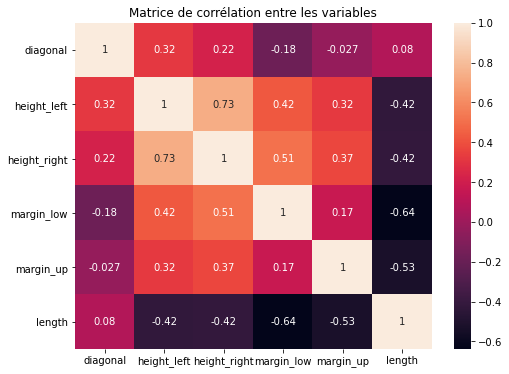

In [34]:
# Matrice de corrélation 
corr_df = infos_billet_pca.corr(method='pearson')
plt.figure(figsize=(8, 6))
seaborn.heatmap(corr_df, annot=True)
plt.title('Matrice de corrélation entre les variables')
#plt.show()
plt.savefig("../P6/image/matrice de corrélation des variables.png")

* On note plusieurs corrélations entre nos variables
* height_right et height left sont très corrélés voir le coefficient de corrélation de 0.73
* Margin_low est plus corrélé à height_rigth (0.51) et height_left (0.42) plutôt qu'à margin_up ( 0.17)

* les variables length et margin low sont aussi fortement corrélées à is_genuine (


In [35]:
# Retrouvons les coordonnées des composants principaux au niveau de chaque axe
pcs = pca.components_
pcs

array([[ 0.07327499,  0.47550205,  0.4918214 ,  0.43102671,  0.35253984,
        -0.46537288],
       [ 0.77963908,  0.33925019,  0.23554253, -0.32053699, -0.14111974,
         0.31453645],
       [-0.08889419,  0.12276016,  0.15383022,  0.5128076 , -0.82114881,
         0.12691346],
       [-0.55973158,  0.2780463 ,  0.45893794, -0.22652773,  0.13533955,
         0.57370304],
       [-0.22509444,  0.71592059, -0.48699285, -0.31190784, -0.1939426 ,
        -0.25441684],
       [ 0.12216606,  0.23213146, -0.4808135 ,  0.54763041,  0.35437971,
         0.52395111]])

### Projection des individus sur le premier plan factoriel

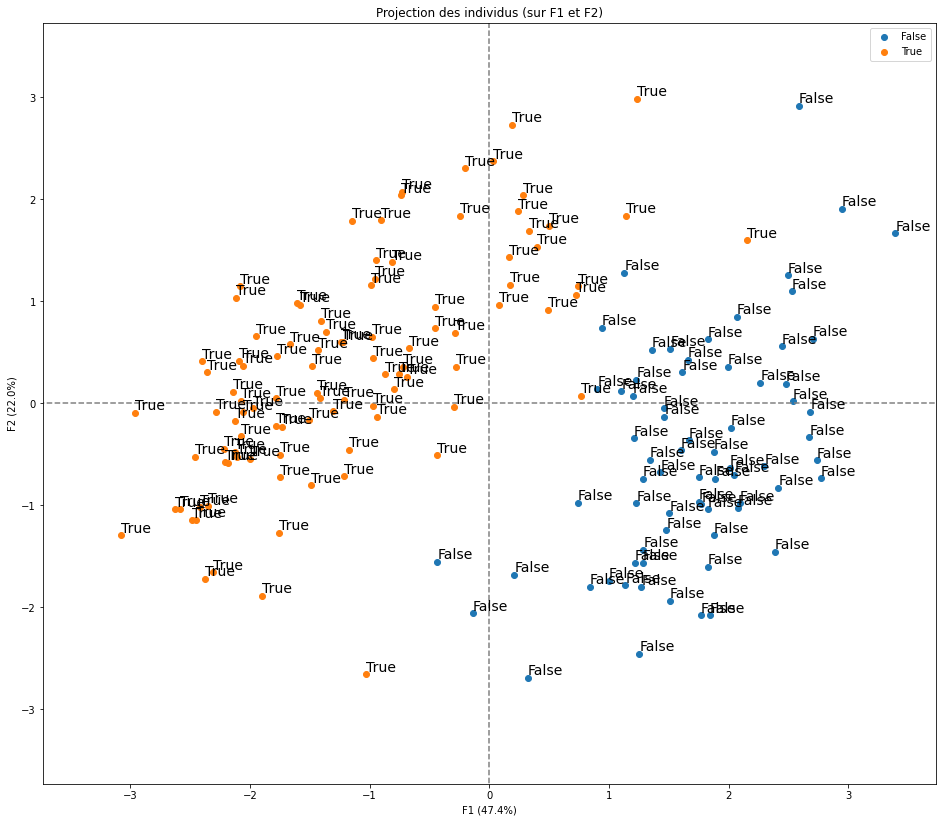

In [36]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names),illustrative_var=names)

* L'ACP sépare distinctement les deux type de billet Nous avons les authentiques à gauche et les faux à droite.
Notons que quelques billets considérés comme vrai se retrouvent dans le groupe des faux nous verons en detail pourquoi.

In [37]:
# Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1) 
Contri_ind_iner = pd.DataFrame({'ID':infos_billet['is_genuine'],'d_i':di})
Contri_ind_iner.sort_values(by='d_i',ascending =  False )
#print(pd.DataFrame({'ID':infos_billet['is_genuine'],'d_i':di}))

,ID,d_i
166,False,20.625650
0,True,18.410598
4,True,18.039567
122,False,16.790944
39,True,15.052608
...,...,...
59,True,1.484454
76,True,1.435202
85,True,1.431664
98,True,0.878319


### Qualité de représentation des individus

In [38]:
#qualité de représentation des individus -COS2 
cos2 = X_scaled**2 
for j in range(p): cos2[:,j] = cos2[:,j]/di 
print(pd.DataFrame({'id':names,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

        id    COS2_1    COS2_2
0     True  0.009966  0.387059
1     True  0.144681  0.221301
2     True  0.026526  0.214046
3     True  0.044250  0.193034
4     True  0.007140  0.084171
..     ...       ...       ...
165  False  0.040243  0.039485
166  False  0.596567  0.150404
167  False  0.351977  0.054764
168  False  0.044920  0.030156
169  False  0.000755  0.009276

[170 rows x 3 columns]


In [39]:
#vérifions la théorie que la somme des cos pour tout les individus sur l'ensemble des facteurs = 1:  somme en ligne des cos2 = 1 
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


### Contribution des individus

In [40]:
#contributions aux axes 1 et 2 uniquement
ctr = coord**2 
for j in range(p): 
    ctr[:,j] = ctr[:,j]/(n*valeur_propre[j]) 
print(pd.DataFrame({'id':names,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))

        id     CTR_1     CTR_2
0     True  0.009527  0.011359
1     True  0.009149  0.001228
2     True  0.007997  0.000010
3     True  0.008715  0.000035
4     True  0.011863  0.000754
..     ...       ...       ...
165  False  0.012620  0.000160
166  False  0.013729  0.037704
167  False  0.008778  0.003174
168  False  0.001123  0.004202
169  False  0.004653  0.005175

[170 rows x 3 columns]


In [41]:
#vérifions la théorie 
print(np.sum(ctr,axis=0))

[0.99411765 0.99411765 0.99411765 0.99411765 0.99411765 0.99411765]


### Représentation des variables sur les axes : élément d'interprétation du cercle des corrélations
Nous utiliserons les valeurs propres pour interpréter la représentation des variables

### Corrélation des variables avec les axes

In [42]:
#racine carrée des valeurs propres 
sqrt_valeur_propre = np.sqrt(valeur_propre)

In [43]:
#corrélation des variables avec les axes 
corvar = np.zeros((p,p)) 
for k in range(p): 
    corvar[:,k] = pcs[k,:] * sqrt_valeur_propre[k] 
#affichons la matrice des corrélations variables x facteurs 
print(corvar)

[[ 0.12399984  0.89750708 -0.08239513 -0.40152883 -0.11876949  0.05386727]
 [ 0.80466983  0.39053898  0.11378517  0.19945918  0.37775042  0.10235485]
 [ 0.83228631  0.2711525   0.14258369  0.32922354 -0.25695832 -0.21200743]
 [ 0.7294063  -0.36899666  0.47531625 -0.16250184 -0.16457596  0.24146933]
 [ 0.59658665 -0.16245462 -0.76111465  0.09708712 -0.10233243  0.15625837]
 [-0.78752871  0.36208895  0.11763482  0.41155139 -0.13424124  0.23102831]]


* notons que les variables sont en ligne et les facteurs en colonnes

In [44]:
# stockons ces données dans un dataframe 
# on affiche pour les deux premiers axes uniquement
correlation_var_axe = pd.DataFrame({'id':features,'COR_1':corvar[:,0],'COR_2':corvar[:,1]})
print(correlation_var_axe)

             id     COR_1     COR_2
0      diagonal  0.124000  0.897507
1   height_left  0.804670  0.390539
2  height_right  0.832286  0.271153
3    margin_low  0.729406 -0.368997
4     margin_up  0.596587 -0.162455
5        length -0.787529  0.362089


**Note:**
- sur F1 : height_left  , height_right  , margin_low  ,margin_up  sont fortement correlée positivement et length  y est corrélé négativement.
- sur F2 : uniquement diagonal  est corrélé  la composante 2

### Qualité de représentation des variables (COS²)
Calculons la qualité de représentation des variables en mettant d'abord le corrélation au carrré

In [45]:
#Qualité de représentation des variable (cosinus carré des variables) sur les deux premier axes 
cos2var = corvar**2 
print(pd.DataFrame({'id':features,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.015376  0.805519
1   height_left  0.647494  0.152521
2  height_right  0.692701  0.073524
3    margin_low  0.532034  0.136159
4     margin_up  0.355916  0.026392
5        length  0.620201  0.131108


### contributions des variables à la formation des axes

In [46]:
#contributions  des variable
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/valeur_propre[k] #on n'affiche que pour les deux premiers axes 
print(pd.DataFrame({'id':features,'CTR_1':ctrvar[:,0],'CTR_2':ctrvar[:,1]}))

             id     CTR_1     CTR_2
0      diagonal  0.005369  0.607837
1   height_left  0.226102  0.115091
2  height_right  0.241888  0.055480
3    margin_low  0.185784  0.102744
4     margin_up  0.124284  0.019915
5        length  0.216572  0.098933


- l'axe F1 est essentiellement formé par les variables height_left  ,height_right ,length  ,margin_low ,margin_up  
- Diagonal contribu presque seul à la formation de l'axe F2

## Mission 2 : Classification non supervisée (l'algorithme Kmeans)

In [47]:
from sklearn.cluster import KMeans

In [48]:
# Déterminons d'abord le nombre de cluster idéal par la Méthode du Coude
inertia = [] #créons une liste qu'on nomme inertia
K_range = range(1, 20 ) # créons une rangé de valeur
for k in K_range: 
    model = KMeans(n_clusters=k).fit(X) # on crée un model  qu'on entraine 
    inertia.append(model.inertia_) # on calcul le coût qu'on va rentrer dans notre liste

C:\Users\mefoo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


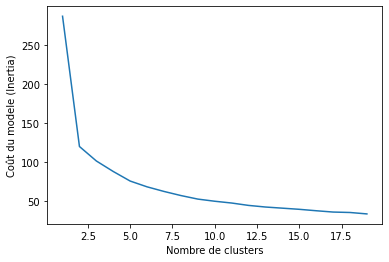

In [49]:
#Tracons la courbe et identifions la zone du coude
plt.plot(K_range,inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du modele (Inertia)')
plt.savefig("../P6/image/Graphique résultant de la méthode du coude.png")

627.2183861833662

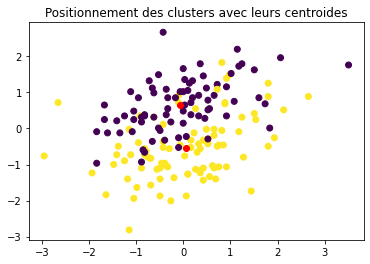

In [50]:

# Nombre de clusters souhaités
n_clust = 2
# Nous ne réduisont plus car on l'a deja fait plus haut
X = X_scaled
# nous considérerons les variables utilisées par la CAH

model= KMeans(n_clusters =n_clust)
model.fit(X) # entrainons notre jeux de donnée

# récupération des clusters attribués à chaque individus
Clusters =  model.labels_

model.predict(X) # pour voir comment sont affichées nos donneés
plt.scatter(X[:,0], X[:,1],c = model.predict(X))
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1],c='r')
plt.title("Positionnement des clusters avec leurs centroides")
plt.savefig("../P6/image/clustering avec les centroides.png")

# calcul de l'inertie
model.inertia_ # pour trouver la somme des distances entre les points d'un cluster et le centroide son unité dépend de celle des variables utilisées

In [51]:
# coordonnées des centroids
cordo_centroides = model.cluster_centers_
cordo_centroides

array([[-0.06412378,  0.64653217,  0.72076527,  0.81585838,  0.64246416,
        -0.87782484],
       [ 0.05309173, -0.53530083, -0.59676264, -0.67549565, -0.53193269,
         0.72680122]])

In [52]:

clusters=model.predict(X)
# Consignons nos classes dans un dataframe
billet = pd.DataFrame({"is_genuine": names, "cluster": clusters})


In [53]:
billet['cluster'].value_counts()

1    93
0    77
Name: cluster, dtype: int64

In [54]:
print("Matrice de confusion")
C_inertie = pd.crosstab(Clusters,names)  #tableau croisés des facteurs (Cluster et names)
C_inertie.index = ['cluster1','cluster2']
C_inertie.columns = ['Faux','Vrais']
C_inertie
#seaborn.heatmap(C_inertie, annot=True, annot_kws={"size": 16})
#plt.savefig("../P6/image/matrice de confusion 1 echantion de départ")

Matrice de confusion


,Faux,Vrais
cluster1,69,8
cluster2,1,92


On remarque que 
- Le cluster 1 est constitué essentiellement de faux billets (69) et de 8 vrais billets
- On retrouve la majorité de vrais billets (92) dans le cluster 2 et uniquement 1 billet dans ce dernier

In [55]:
C_inertie.values.sum()

170

In [56]:
# Trouvons le pourcentage de la qualité de repartition de nos individus suivant les groupes
print('{} % des billets sont bien classés'.format(round((C_inertie.iloc[0,0] + C_inertie.iloc[1,1])/ C_inertie.values.sum()*100, 2)))

94.71 % des billets sont bien classés


## ACP 2: Acp après la classification non suppervisée

Nous afficherons uniquement le nuage des individus après la CAH car le reste est inchangé.

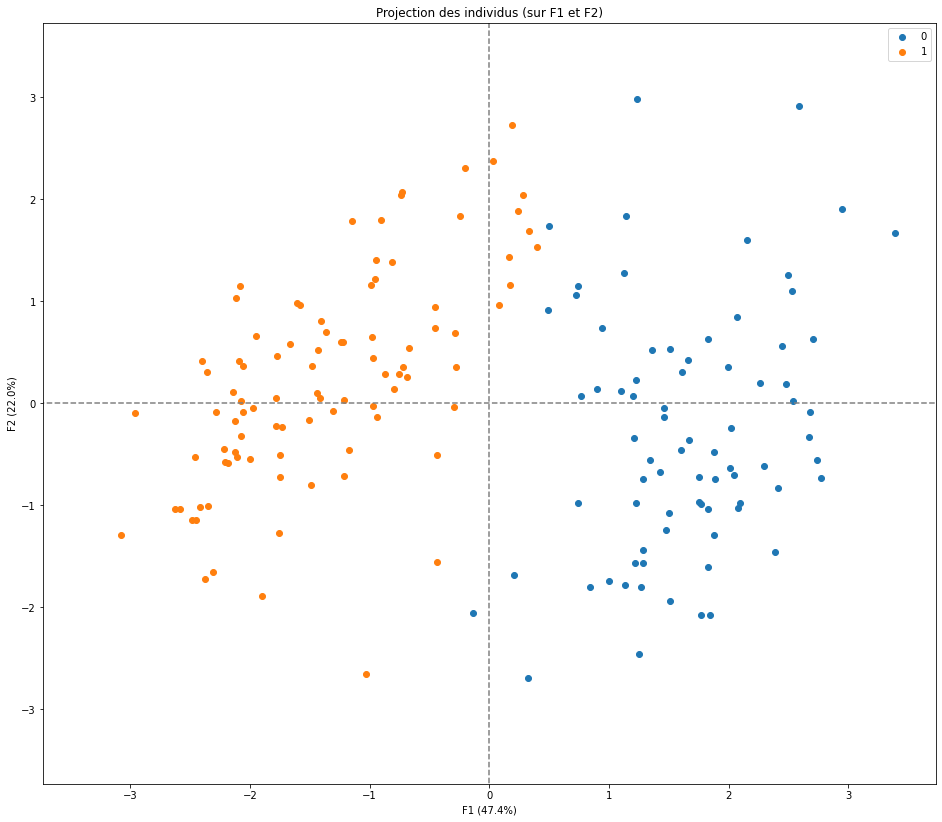

In [57]:
# projection des billet sur le premier plan factoriel en fonction des clusters.
display_factorial_planes(X_projected, n_comp, pca,[(0,1)],illustrative_var=np.array(Clusters))

**Conclusion** 
Nous constatons que certains billets prètent à confusion car on retouve dans notre échantillons
- **1 faux  qui se disimule parmis les vrais billets**
- **7 vrai qui se confondent au faux billets**

## Mission 3 : Regression logistique

###  1) Régression logistique avec statsmodels

In [58]:
#importation de la librairie de calcul
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Pour le traitement, nous allons transformer la variable is_genuine pour :

True = 0
False = 1

In [59]:
# Effectuons le remplace pour True mettre 0 si  non mettre 1
infos_billet['is_genuine'] = infos_billet['is_genuine'].apply(lambda x: 0 if x == True else 1)
infos_billet["is_genuine"] = infos_billet["is_genuine"].astype('category') # changeons le type de notre variable

In [60]:
# Isolons la variable cible y et les variables explicatives X dans deux structures distinctes 
X = infos_billet.iloc[:,[1,2,3,4,5,6]]
y = infos_billet.iloc[:,0]

* Créons un echantillon d'apprentissage ( x_train, y_train) et un echantillon test (x_test et y_test)

In [61]:
from sklearn.model_selection import train_test_split

# Division de la base de donnée
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(136, 6)
(34, 6)


In [62]:
# on ajuste le modèle
modele_sm = sm.Logit(y_train, x_train)
result = modele_sm.fit(method='bfgs')

         Current function value: 0.013877
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


C:\Users\mefoo\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [63]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                  136
Model:                          Logit   Df Residuals:                      130
Method:                           MLE   Df Model:                            5
Date:                Sun, 26 Dec 2021   Pseudo R-squ.:                  0.9797
Time:                        06:24:41   Log-Likelihood:                -1.8873
converged:                      False   LL-Null:                       -92.792
Covariance Type:            nonrobust   LLR p-value:                 2.198e-37
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal         2.4705     16.331      0.151      0.880     -29.537      34.478
height_left      8.1077     17.242      0.470      0.638     -25.686      41.901
height_right     7.7742     22.461      0.34

Effectuons à présent la prédiction sur la base des tests 

In [64]:
x_test['prediction_sm'] = round((result.predict(x_test)*100),2)
x_test

<ipython-input-64-7f5206807e55>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction_sm'] = round((result.predict(x_test)*100),2)


,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_sm
139,171.60,104.37,104.20,5.82,3.08,112.84,100.00
30,172.19,104.05,103.81,3.90,3.22,113.52,0.00
119,171.51,104.13,103.90,4.99,3.60,111.23,100.00
29,171.84,103.75,103.38,4.08,2.70,113.72,0.00
144,171.56,103.80,103.87,5.66,2.98,112.95,100.00
163,171.78,104.07,104.16,5.77,3.30,111.27,100.00
166,173.01,104.59,104.31,5.04,3.05,110.91,100.00
51,172.22,104.48,104.06,4.59,2.91,112.82,0.61
105,171.99,104.18,104.20,5.26,3.23,111.83,100.00
60,172.11,103.67,103.43,4.19,2.98,113.09,0.00


In [65]:
x_test['prediction_sm'].describe()

count     34.000000
mean      38.245882
std       49.303334
min        0.000000
25%        0.000000
50%        0.000000
75%      100.000000
max      100.000000
Name: prediction_sm, dtype: float64

### 2) Regression logistique avec Scikit learn

In [66]:
# importons les librairies pour le machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [67]:
#librairie scipy
import scipy


In [68]:
#comptabilisons les effectifs par classes
print (y_train.value_counts())
print (y_test.value_counts())

0    78
1    58
Name: is_genuine, dtype: int64
0    22
1    12
Name: is_genuine, dtype: int64


### Modélisation et inspection des résultats

In [69]:
# Création du modèle
model = LogisticRegression() # instanciation
model_sk = model.fit(x_train,y_train)

In [70]:
#calcul des probabilités d'affectation sur l'échantillon test
proba01 = model.predict_proba(x_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]])     #remplacement de ztrain par x_train
#affichage des 5 premières valeurs
print(proba01[:5,:])

[[0.11707393 0.88292607]
 [0.98961955 0.01038045]
 [0.0247368  0.9752632 ]
 [0.99749444 0.00250556]
 [0.36586954 0.63413046]]


* nous avons les probabilités d'appartenance aux vrais ou aux faux billets
- la première colonne correspond aux faux billets
- la deuxième colonne aux vrais billets


* Les probabilités sont sur deux colonnes. La première n°0, pour l’appartenance à (Y = 0) est la probabilité qu'un billet soit vrai et la seconde pour (Y = 1) correspond aux probabilités qu'un billet soit faux. Nous récupérons cette dernière.

In [71]:
#récupération de la colonne n°1 qui est la probalilité que le billet soit vrai
proba1 = proba01[:,0]
#description statistique
print(scipy.stats.describe(proba1))


DescribeResult(nobs=34, minmax=(0.0006364613351920179, 0.9974944351809677), mean=0.6298127627753645, variance=0.19107320809909342, skewness=-0.5717108239014428, kurtosis=-1.5670394223055044)


In [72]:
# ajoutons cette probabilité dans notre dataset pour comparer les résultats des 2 méthodes
x_test['prob_vrai_billet'] = proba1
x_test

<ipython-input-72-61210debb4c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prob_vrai_billet'] = proba1


,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_sm,prob_vrai_billet
139,171.60,104.37,104.20,5.82,3.08,112.84,100.00,0.117074
30,172.19,104.05,103.81,3.90,3.22,113.52,0.00,0.989620
119,171.51,104.13,103.90,4.99,3.60,111.23,100.00,0.024737
29,171.84,103.75,103.38,4.08,2.70,113.72,0.00,0.997494
144,171.56,103.80,103.87,5.66,2.98,112.95,100.00,0.365870
163,171.78,104.07,104.16,5.77,3.30,111.27,100.00,0.004079
166,173.01,104.59,104.31,5.04,3.05,110.91,100.00,0.006649
51,172.22,104.48,104.06,4.59,2.91,112.82,0.61,0.761299
105,171.99,104.18,104.20,5.26,3.23,111.83,100.00,0.045402
60,172.11,103.67,103.43,4.19,2.98,113.09,0.00,0.978673


### Test complémentaires avec sklearn

In [73]:
#Calculer les estimations du rapport de cotes

model_odds = np.exp(model.coef_)
model_odds

array([[ 1.47868824,  1.83062114,  2.62609876, 13.08590353,  3.98631062,
         0.11099362]])

In [74]:
#Print model parameters
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 [0.0139014]
Coefficients: 
 [[ 0.39115537  0.60465533  0.96549939  2.57153558  1.38286615 -2.19828257]]


In [75]:
from sklearn.metrics import confusion_matrix

#x_test = x_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
conf_matrix_train = confusion_matrix(y_train, model.predict(x_train))

#Créons un DataFrame à partir du tableau

df_conf_train = pd.DataFrame(conf_matrix_train, columns=['réel_Vrai',"réel_Faux"])
df_conf_train.index = ['prédit_Vrai',"prédit_Faux"]
df_conf_train

,réel_Vrai,réel_Faux
prédit_Vrai,77,1
prédit_Faux,2,56


In [76]:

x_test = x_test[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
conf_matrix_test = confusion_matrix(y_test, model.predict(x_test))

#Créons un DataFrame à partir du tableau

df_conf_test = pd.DataFrame(conf_matrix_test, columns=['réel_Vrai',"réel_Faux"])
df_conf_test.index = ['prédit_Vrai',"prédit_Faux"]
df_conf_test

,réel_Vrai,réel_Faux
prédit_Vrai,22,0
prédit_Faux,0,12


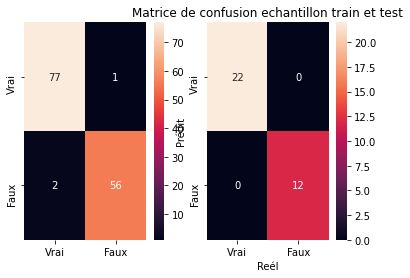

In [77]:
#Affichage avec Seaborn
fig, ax =plt.subplots(1,2)
seaborn.heatmap(conf_matrix_train, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],ax=ax[0])
seaborn.heatmap(conf_matrix_test, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],ax=ax[1])

font = {'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
plt.xlabel("Reél")
plt.ylabel("Prédit")
plt.title("Matrice de confusion echantillon train et test")
plt.show()
fig.savefig('../P6/image/matrice_confusion 2 echantillon_Train_Test.png')




### Déterminons les métrics de classification pour évaluer notre modèle
<br>

### Cas de l'echantillon test

In [78]:
# Calcul pour évaluer la précision de notre modèle
df_conf = pd.DataFrame(conf_matrix_test,index = ['prédit_Vrai','prédit_Faux'],
columns=['réel_Vrai','réel_Faux'])
df_conf
TP  =  df_conf . iloc [0,0  ]# prédit_Vrai et réel_Vrai
FP  =  df_conf . iloc [0,1] # prédit_Vrai et réel_Faux
TN  =  df_conf . iloc [1,1] # prédit_Faux et réel_Faux 
FN  =  df_conf . iloc [1,0] # prédit_Faux et réel_Vrai

In [79]:
#Reproduire le rapport de classification par calcul

TPR=(float(TP) / (TP + FN))
TPN=(float(TN) / (TN + FP)) 
PPV=(float(TP) / (TP + FP)) 
NPV=(float(TN) / (TN + FN)) 
FNR=(float(FN) / (FN + TP))
FPR=(float(FP) / (FP + TN))
FDR=(float(FP) / (FP + TP))
FOR=(float(FN) / (FN + TN))
TS=(float(TP) / (TP+FN + FP))
ACC=(float(TP+TN) / (TP+FP+FN + TN))  #print((TP + TN) / float(len(y_test)))
F1=2*TP/(2*TP+FP+FN)

print ("sensitivity, recall, hit rate, or true positive rate (TPR): ",TPR)
print ("specificity, selectivity or true negative rate (TNR): ",TPN)
print ("precision or positive predictive value (PPV): ",PPV)
print ("negative predictive value (NPV): ",NPV)
print ("miss rate or false negative rate (FNR): ",FNR)
print ("fall-out or false positive rate (FPR): ",FPR)
print ("false discovery rate (FDR): ",FDR)
print ("false omission rate (FOR): ",FOR)
print ("Threat score (TS) or Critical Success Index (CSI): ",TS)
print("")
print ("accuracy (ACC): ",ACC)
print ("F1: ",F1)


sensitivity, recall, hit rate, or true positive rate (TPR):  1.0
specificity, selectivity or true negative rate (TNR):  1.0
precision or positive predictive value (PPV):  1.0
negative predictive value (NPV):  1.0
miss rate or false negative rate (FNR):  0.0
fall-out or false positive rate (FPR):  0.0
false discovery rate (FDR):  0.0
false omission rate (FOR):  0.0
Threat score (TS) or Critical Success Index (CSI):  1.0

accuracy (ACC):  1.0
F1:  1.0


In [80]:
#Accuracy statistics
from sklearn.metrics import accuracy_score,average_precision_score,precision_score,recall_score,f1_score, confusion_matrix

#print('Accuracy Score:', metrics.accuracy_score(y_test, proba01))  
#print('Average Precision Score:', metrics.average_precision_score(y_test, proba01)) 
#print('F1 Score:', metrics.f1_score(y_test, proba01)) 
#print('Precision:', metrics.precision_score(y_test, proba01)) 
#print('Recall:', metrics.recall_score(y_test, proba01))

#Create classification report
#class_report=classification_report(y_test, proba01)
#print(class_report)

### Cas de l'echantillon d'entrainement

In [81]:
# Calcul pour évaluer la précision de notre modèle
df_conf = pd.DataFrame(conf_matrix_train,index = ['prédit_Vrai','prédit_Faux'],
columns=['réel_Vrai','réel_Faux'])
df_conf
TP  =  df_conf . iloc [0,0  ]# prédit_Vrai et réel_Vrai
FP  =  df_conf . iloc [0,1] # prédit_Vrai et réel_Faux
TN  =  df_conf . iloc [1,1] # prédit_Faux et réel_Faux 
FN  =  df_conf . iloc [1,0] # prédit_Faux et réel_Vrai

In [82]:
#Reproduire le rapport de classification par calcul

TPR=(float(TP) / (TP + FN))
TPN=(float(TN) / (TN + FP)) 
PPV=(float(TP) / (TP + FP)) 
NPV=(float(TN) / (TN + FN)) 
FNR=(float(FN) / (FN + TP))
FPR=(float(FP) / (FP + TN))
FDR=(float(FP) / (FP + TP))
FOR=(float(FN) / (FN + TN))
TS=(float(TP) / (TP+FN + FP))
ACC=(float(TP+TN) / (TP+FP+FN + TN))  #print((TP + TN) / float(len(y_test)))
F1=2*TP/(2*TP+FP+FN)

print ("sensitivity, recall, hit rate, or true positive rate (TPR): ",TPR)
print ("specificity, selectivity or true negative rate (TNR): ",TPN)
print ("precision or positive predictive value (PPV): ",PPV)
print ("negative predictive value (NPV): ",NPV)
print ("miss rate or false negative rate (FNR): ",FNR)
print ("fall-out or false positive rate (FPR): ",FPR)
print ("false discovery rate (FDR): ",FDR)
print ("false omission rate (FOR): ",FOR)
print ("Threat score (TS) or Critical Success Index (CSI): ",TS)
print("")
print ("accuracy (ACC): ",ACC)
print ("F1: ",F1)


sensitivity, recall, hit rate, or true positive rate (TPR):  0.9746835443037974
specificity, selectivity or true negative rate (TNR):  0.9824561403508771
precision or positive predictive value (PPV):  0.9871794871794872
negative predictive value (NPV):  0.9655172413793104
miss rate or false negative rate (FNR):  0.02531645569620253
fall-out or false positive rate (FPR):  0.017543859649122806
false discovery rate (FDR):  0.01282051282051282
false omission rate (FOR):  0.034482758620689655
Threat score (TS) or Critical Success Index (CSI):  0.9625

accuracy (ACC):  0.9779411764705882
F1:  0.9808917197452229


### Distribution des probabiltés

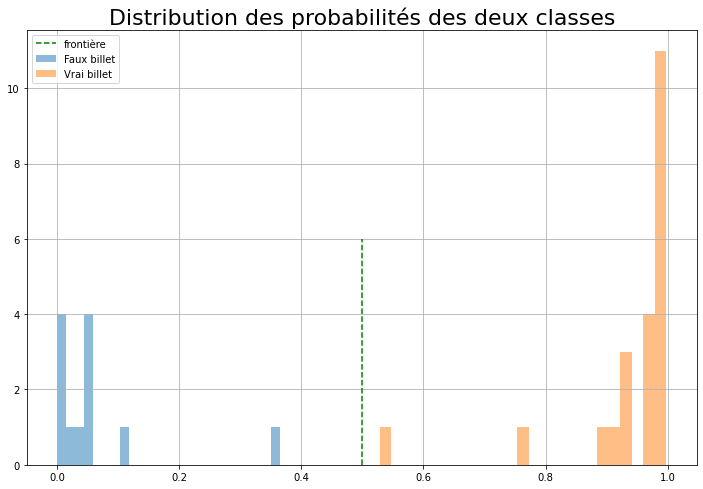

In [83]:
df_proba = pd.DataFrame(proba1, columns=['proba'])
df_proba['is_genuine'] = y_test.values

fig = plt.figure(figsize=(12,8))
df_proba[df_proba['is_genuine'] == 1]['proba'].hist(bins=25, label='Faux billet', alpha=0.5)
df_proba[df_proba['is_genuine'] == 0]['proba'].hist(bins=25, label='Vrai billet', alpha=0.5)
plt.plot([0.5, 0.5], [0, 6], 'g--', label="frontière")
plt.title('Distribution des probabilités des deux classes', fontsize=22)
plt.legend()
fig.savefig('../P6/image/LOGIT_distri_probas.png')

Plus l’aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe ROC

### La courbe ROC (Receiver Operating Characteristic)
Elle est en fait la proportion de vrais positifs en fonction de la proportion de faux positifs

In [84]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr1, tpr1, seuil1 = roc_curve(y_test, proba01[:, 1], pos_label=model.classes_[1], drop_intermediate=False)
df_truepos = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1, seuil=seuil1)).copy()
df_truepos.sample(10)

,fpr,tpr,seuil
33,0.954545,1.000000,0.004384
14,0.090909,1.000000,0.238701
11,0.000000,0.916667,0.882926
16,0.181818,1.000000,0.094698
28,0.727273,1.000000,0.010853
32,0.909091,1.000000,0.007220
24,0.545455,1.000000,0.017743
5,0.000000,0.416667,0.975263
22,0.454545,1.000000,0.024396
31,0.863636,1.000000,0.008763


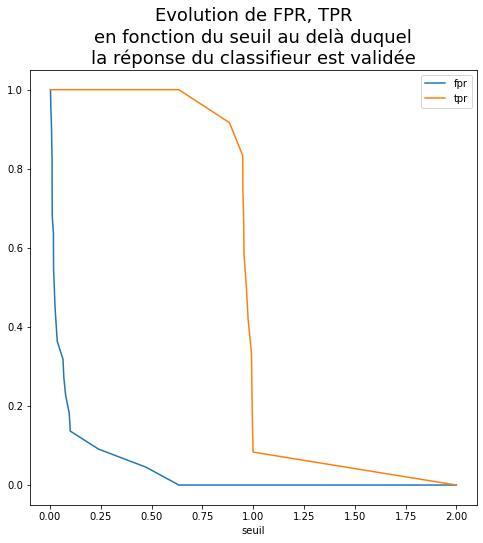

In [85]:
ax = df_truepos.plot(x="seuil", y=['fpr', 'tpr'], figsize=(8, 8))
ax.set_title("Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée", fontsize=18);
#plt.show()

FPR(False Positive Rate/taux de faux positif) c'est lerreur de classification
TPR(True Positive Rate/ taux de vrai positive)

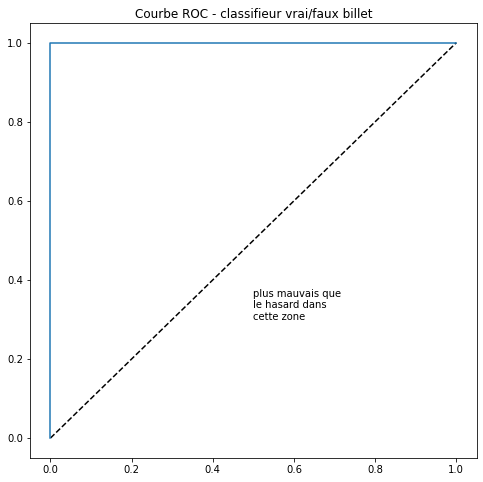

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr1, tpr1) 
ax.plot(fpr1, tpr1)
ax.set_title('Courbe ROC - classifieur vrai/faux billet')
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
plt.show()
fig.savefig('../P6/image/LOGIT_courbe_ROC.png')

In [87]:
print("La mesure AUC est ici égale à",round(aucf,2))

La mesure AUC est ici égale à 1.0


### Testons notre algorithme scikit-learn sur un échantillon exemple

In [88]:
example=pd.read_csv("example.csv")

In [89]:
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [90]:
#creation des variables et des identifiants
X_example = example[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
id_example = example[["id"]]

In [91]:
#from sklearn.linear_model import LogisticRegression
X_example = example.drop(['id'], axis=1).values

In [92]:
probabilites = model.predict_proba(X_example)
probabilites

array([[0.04371895, 0.95628105],
       [0.01252803, 0.98747197],
       [0.02997659, 0.97002341],
       [0.85774335, 0.14225665],
       [0.99484976, 0.00515024]])

In [93]:
#score de presence : Probalilité de chance que le billet soit vrai (is_genuine = 0)
score_example = probabilites[:,0]
print(score_example)

[0.04371895 0.01252803 0.02997659 0.85774335 0.99484976]


In [94]:
#affichage du dataframe final
example["proba_True"] = score_example
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_True
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.043719
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.012528
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.029977
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.857743
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.994850


Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. sur cette base nous pouvons donc créer notre colonne is_genuine qui aura pour modalité **non pour faux billet** et **oui pour vrai billet**.

In [95]:
#calcul de la variable is_genuine
example["is_genuine"] = np.where(example["proba_True"]<=0.5, 'Non', 'Oui')
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba_True,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.043719,Non
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.012528,Non
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.029977,Non
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.857743,Oui
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.994850,Oui


In [96]:
#traitement du Dataframe pour une meilleure compréhension :
fichier_exemple_teste = example[["id","proba_True","is_genuine"]].rename(columns={"id":"Identifiant du billet testé",
                                                                                 "proba_True":"Probabilité de vrai billet (%)",
                                                                                 "is_genuine":"Est authentique ?"})
fichier_exemple_teste["Probabilité de vrai billet (%)"] = round((fichier_exemple_teste["Probabilité de vrai billet (%)"]*100),2)
fichier_exemple_teste

,Identifiant du billet testé,Probabilité de vrai billet (%),Est authentique ?
0,A_1,4.37,Non
1,A_2,1.25,Non
2,A_3,3.00,Non
3,A_4,85.77,Oui
4,A_5,99.48,Oui


#### REPRESENTONS LES BILLETS DE NOTRE FICHIER EXEMPLE SUR LE PREMIER PLAN FACTORIEL

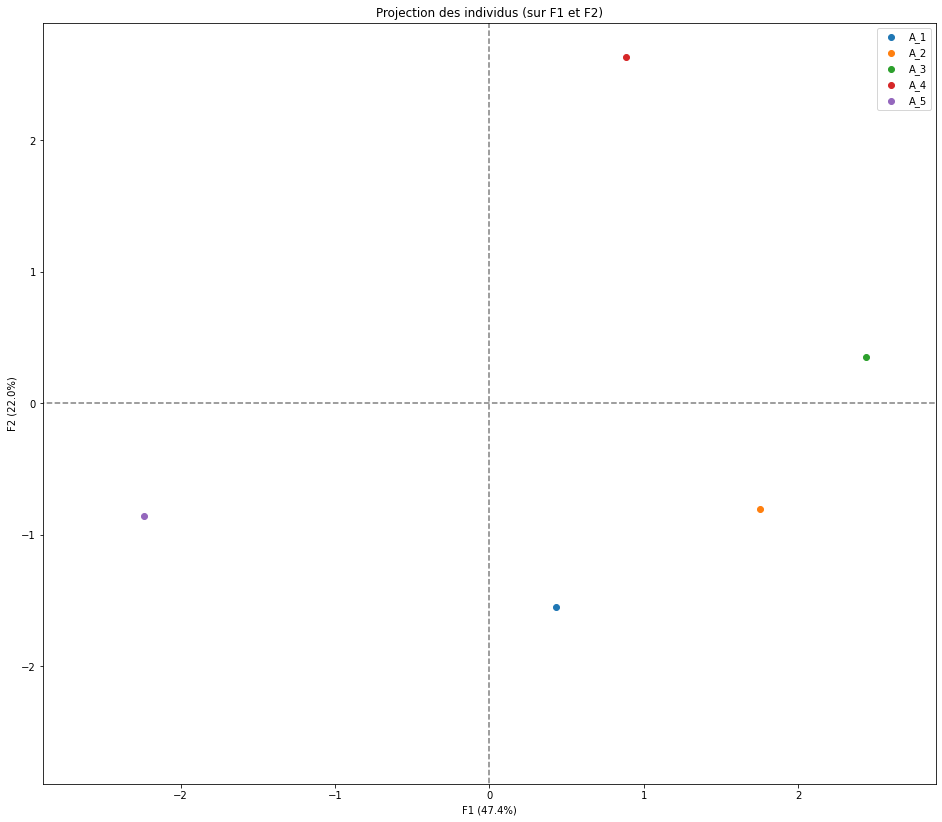

In [97]:
# projection des billet sur le premier plan factoriel en fonction des clusters.
X_scaled = std_scale.transform(X_example) # centrage et reduction
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=example['id'])

Les billets du fichier exemple  projetés sur le premier plan factoriel respectent la disposition des billets ayant servir à concevoir le programme de détection de faux billet.